## **Análisis de Tópicos en Conversaciones de Servicio al Cliente**

El análisis realizado sobre el corpus implicó la aplicación de diferentes modelos de procesamiento de lenguaje natural (NLP) para explorar patrones y estructuras en las desgrabaciones de 640 llamadas entre clientes y agentes de un contact center. Se describen brevemente los resultados de los modelos utilizados: LSA, LDA y BERTopic.



### **Instalar e importar librerías necesarias**

In [1]:
!pip -q install unidecode

In [2]:
!pip -q install bertopic

In [3]:
import os
import glob
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px

from gensim import corpora, models
from gensim.models import CoherenceModel

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import re
import unidecode
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from bertopic import BERTopic
import umap

from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')

pd.set_option('display.max_colwidth', None) # para que no me corte todo el texto el dataframe

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### **Carga de datos**

Primero se a cargan los datos y se aplica algo de preprocesamiento sobre ellos.

In [4]:
def preprocesar_texto(texto):

    # Eliminar puntos y símbolos
    texto = re.sub(r'[,;.:¡!¿?@#$%&[\](){}<>~=+\-*/|\\_^`"\']', '', texto)

    #Eliminar saludos y otros
    #palabras_eliminar = ['hola', 'chau', 'muchas', 'gracias', 'igual', 'luego', 'chao', 'buenas', 'tarde', 'tardes', 'buenos', 'dias', 'buena', 'dia', 'muchisimas', 'alo', 'buen', 'hasta', 'igualmente', 'perfecto', 'amable', 'agradezco', 'entonces']

    #for palabra in palabras_eliminar:
    #    texto = re.sub(r'\b{}\b'.format(palabra), '', texto, flags=re.IGNORECASE)

    # Eliminar dígitos [0-9]
    texto = re.sub('\d', '', texto)

    # Eliminar acentos
    texto = unidecode.unidecode(texto)

    # Convertir todo a minúsculas
    texto = texto.lower()

    # Eliminar espacios
    texto = texto.strip()

    return texto

def tokenizar(texto):
  stopwords_espanol = set(stopwords.words('spanish'))
  tokens = [token for token in word_tokenize(texto) if token.lower() not in stopwords_espanol]

  return tokens

def lematizar(texto):
    doc = nlp(texto)
    lemas = [token.lemma_ for token in doc]
    return lemas


def stem_palabras(tokens):
    stemmer = SnowballStemmer("spanish")
    return [stemmer.stem(token) for token in tokens]


def cargar_corpus(folder_path):

    # almacenar los df de cada archivo
    dfs = []

    rutas_archivos = os.listdir(folder_path)

    # recorrer los archivos en la carpeta
    for file_name in tqdm(rutas_archivos, 'Leyendo corpus y haciendo prepro') :
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path, sep=';')
            df['prepro'] = df.Pregunta.apply(preprocesar_texto) # aplico prepro
            df['tokens'] = df.prepro.apply(tokenizar)
            df['prepro'] = df.tokens.apply(lambda x : ' '.join(x))
            df["stem_tokens"] = df.tokens.apply(stem_palabras)
            dfs.append(df)

    # Combinar todos los dfs en uno solo
    corpus_df = pd.concat(dfs, ignore_index=True)

    print('Corpus cargado correctamente.')

    return corpus_df

In [5]:
corpus_path = '/content/drive/MyDrive/Etermax/corpus/'
corpus_df = cargar_corpus(corpus_path)

Leyendo corpus y haciendo prepro: 100%|██████████| 640/640 [00:17<00:00, 35.82it/s]


Corpus cargado correctamente.


In [6]:
corpus_df.head(3) # visualizo los datos

Pregunta  \
0   al final . Hola , buenas tardes con Karen . Mira , te quiero hacer una pregunta . Hay una máquina para hacer arepa que se y aparece con un precio de veinte mil pesos , pero por la página , por la , , aparece a treinta y cinco mil no si me puedes corroborar el precio es , claro , , no una , Una que estaba en oferta . No nos mandaron por una que estaba en oferta . Claro . Y sale diecinueve noventa , pero por la página me . Ahora aparece treinta y cinco mil el retiro o qué sector de ? eh ? No tiene . Es cierto . la dirección para es que no , no le ha comprado . quiero corroborar el . cinco , seis uno . . futuro tres Ana Sí , Cinco , seis uno noche ya . Gracias . es que yo la puse por la página . Puse arepas , ya . me apareció la la la como todo tiene como la máquina y viene de regalo una bolsa como para . Cómo aparece el nombre de la foto ? Yo cuando la por la me . Ya marca usted ? Cuando ? , Y viene con promoción con Dóriga . dice ? Bueno , sabes , no ? , ahí dice pongo . Dice con , arepa sí . cuatro . Como que ahora vale . Y se puede hacer ahí ? a verlo con .     
1                                                                                                                                                                                                                                                                                                                                                                                                                                        Buenas tardes , Francisco Moreno . , que mire , los pedidos de mil páginas y un pedido el el lunes pasado no llegue . Pasa que estoy comunicarme con usted y tengo ninguna respuesta Yo . Siete uno . Uno de los tres sea , tengo el primero que se perdió . Veinte , dieciséis ya cero treinta ? Sí , ocho . Ocho . Correcto . Cinco jota Eme cero uno , quieres , te metiste Me por , , que ver el listado . . ahorrando . el primero , claro , de los otros dos . Se lo puedo ver Uno el primero que no he ido . El nueve . Ocho , ocho , dos , ocho . Sí , siete , nueve , . es lo que les . porque tengo mañana entonces lo mismo . Porque que si se me desaparecía te .     
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Hola . Buenas tardes . Habla con María Azcárate . Tengo una consulta . . está demorando el despacho en estos días ? Mon Voisin . , dos cero uno ya . Gracias . que ? del jueves . Veintitrés . Ya , ya . Le agradezco mucho . igual . Hasta luego . Gracias .     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      prepro  \
0  final hola buenas tardes karen mira quiero hacer pregunta maquina hacer arepa aparece precio veinte mil pesos pagina aparece treinta cinco m

### **Graficos**

Grafico para visualizar como una nube de palabras el texto preprocesado. Por otro lado, utilicé un algoritmo de reducción de la dimensionalidad, como PCA, para generar un gráfico en dos dimensiones de los textos y poder analizar su distribución.

In [7]:
def generar_nube_palabras(textos_procesados):
    texto_concatenado = ' '.join(texto for texto in textos_procesados)

    wordcloud = WordCloud(width=1000, height=500).generate(texto_concatenado)

    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

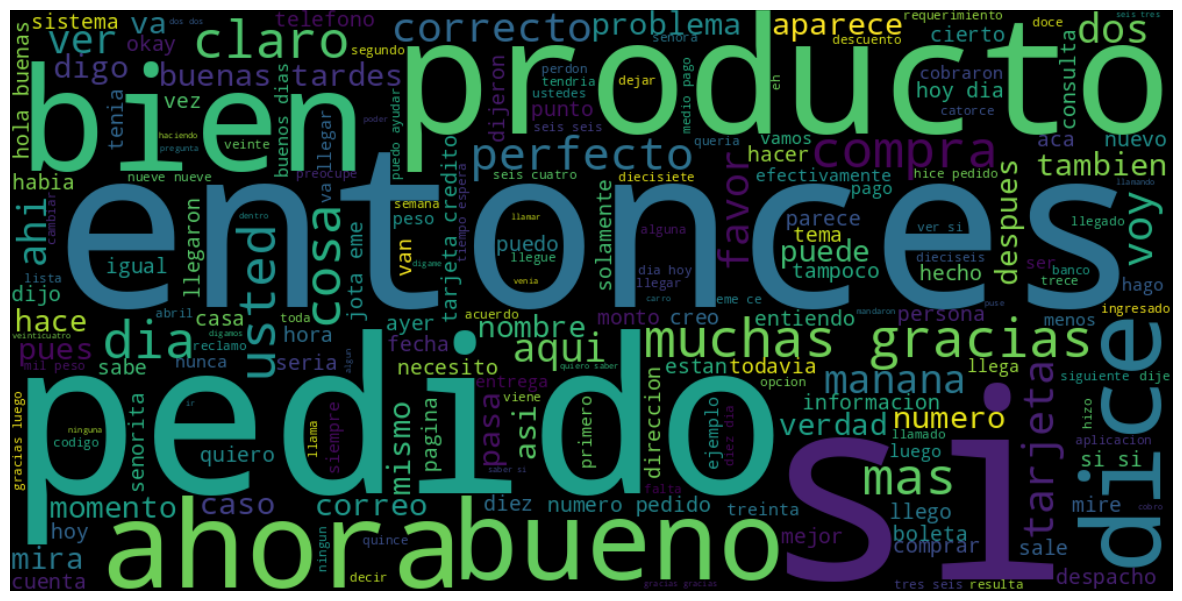

In [8]:
generar_nube_palabras(corpus_df.prepro)

In [9]:
def visualizar_textos_pca(df, text_column, topic_column=None, title='Visualización de Textos con PCA'):
    # Vectorización de texto usando TF-IDF
    vectorizer = TfidfVectorizer()
    X_tfidf = vectorizer.fit_transform(corpus_df[text_column])

    # Reducción de dimensionalidad con PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_tfidf.toarray())

    # Creación de DataFrame para la visualización
    df_visualizacion = pd.DataFrame({
        'Texto': df[text_column],
        'PCA_1': X_pca[:, 0],
        'PCA_2': X_pca[:, 1],
    })


    #  columna de color (topic) si se proporciona
    if topic_column:
        df_visualizacion['Color'] = df[topic_column]

    fig = px.scatter(df_visualizacion, x='PCA_1', y='PCA_2', color='Color' if topic_column else None,
                     title=title,
                     labels={'PCA_1': 'componente principal 1', 'PCA_2': 'componente principal 2'},
                     hover_data=['Texto'])

    fig.update_layout(hoverlabel=dict(align="auto"))

    fig.show()

In [10]:
visualizar_textos_pca(corpus_df, 'prepro')

### **Modelos de generación de tópicos**

In [11]:
dictionary = corpora.Dictionary(corpus_df.stem_tokens)
print(f'Número de tokens: {len(dictionary)}')

Número de tokens: 3067


In [12]:
#dictionary.filter_extremes(no_below=2, no_above = 0.8) #tokens en al menos 2 documentos y en no más del 80% de documentos
#dictionary.compactify()
#print(f'Número de tokens: {len(dictionary)}')

In [13]:
corpus = [dictionary.doc2bow(tokens) for tokens in corpus_df.stem_tokens]

Defino una función para que me calcule un score para cada tópico, el cual mide qué tan coherentes son las palabras dentro de un tópico, con el objetivo de conocer la cantidad óptima.

In [14]:
def get_optimal_number(type_model, corpus, dictionary, tokens, min_topics =2 , max_topics = 15, plot = True):

  coherence_values = []
  for num_topics in tqdm(range(min_topics, max_topics + 1), 'Buscando el número óptimo de tokens'):
      if type_model == 'lda':
        model = models.LdaModel(corpus,
                                num_topics=num_topics,
                                id2word=dictionary,
                                passes=10)
      elif type_model == 'lsa':
        model = models.LsiModel(corpus,
                                num_topics=num_topics,
                                id2word=dictionary)
      else:
        print('Debe especificar tipo de modelo')

      coherence_model = CoherenceModel(model=model,
                                           texts=tokens,
                                           dictionary=dictionary,
                                           coherence='c_v')
      coherence_values.append(coherence_model.get_coherence())

  if plot:
    plt.plot(range(min_topics, max_topics + 1), coherence_values)
    plt.xlabel("Número de tópicos")
    plt.ylabel("Valor de Coherencia")
    plt.title("Valor de Coherencia en función del número de tópicos")
    plt.show()

  optimal_num_topics = coherence_values.index(max(coherence_values)) + min_topics

  print()
  print("Número óptimo de tópicos:", optimal_num_topics)

  return optimal_num_topics

#### **LDA**

Buscando el número óptimo de tokens: 100%|██████████| 14/14 [02:06<00:00,  9.03s/it]


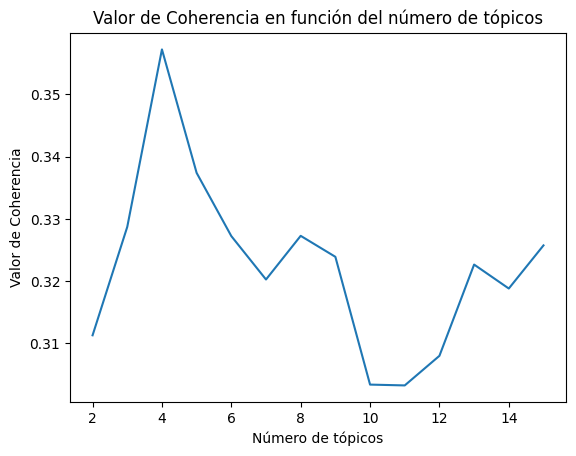


Número óptimo de tópicos: 4


In [15]:
optimal_num_topics = get_optimal_number('lda', corpus, dictionary, corpus_df.stem_tokens)

Calculo la cantidad óptima de tópicos para el modelo LDA.

In [16]:
# Entrenar el modelo LDA
lda_model = models.LdaModel(corpus,
                            num_topics=optimal_num_topics,
                            id2word=dictionary,
                            passes=15)

In [17]:
# Imprimir los tópicos encontrados
for topic in lda_model.print_topics():
    print(topic)

(0, '0.016*"si" + 0.016*"entonc" + 0.014*"pued" + 0.013*"hac" + 0.012*"dic" + 0.011*"ped" + 0.010*"voy" + 0.009*"compr" + 0.009*"cos" + 0.009*"mas"')
(1, '0.024*"ped" + 0.022*"si" + 0.015*"entonc" + 0.014*"lleg" + 0.014*"nuev" + 0.014*"dos" + 0.013*"buen" + 0.013*"graci" + 0.012*"dia" + 0.012*"compr"')
(2, '0.027*"si" + 0.014*"buen" + 0.013*"product" + 0.012*"ped" + 0.012*"pued" + 0.010*"clar" + 0.010*"favor" + 0.010*"hac" + 0.009*"graci" + 0.009*"corre"')
(3, '0.028*"dos" + 0.025*"mil" + 0.024*"si" + 0.015*"cobr" + 0.015*"nuev" + 0.014*"tres" + 0.014*"cuatr" + 0.013*"cos" + 0.013*"product" + 0.012*"ped"')


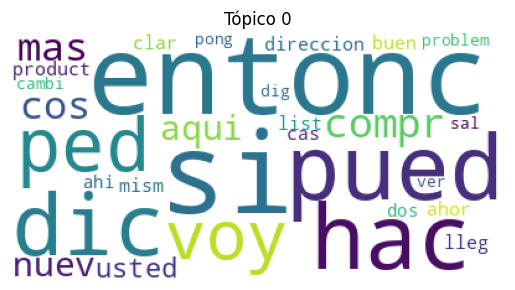

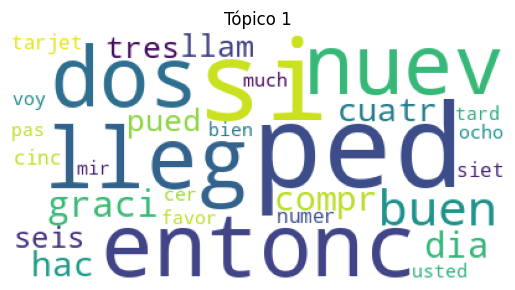

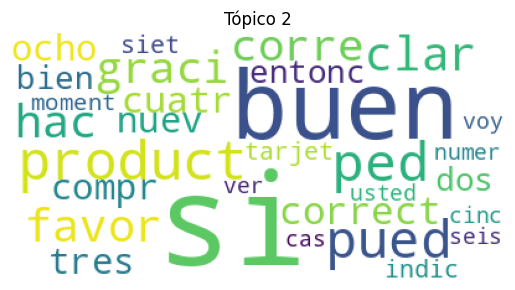

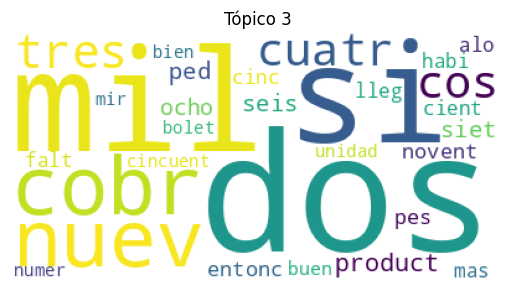

In [18]:
# Visualizar tópicos

def visualizar_topicos(modelo):

  for i in range(0, modelo.num_topics):
    topico = modelo.show_topic(i, 30)
    plt.figure()
    plt.imshow(WordCloud(background_color='white', prefer_horizontal=1.0)
               .fit_words(dict(topico)))
    plt.axis("off")
    plt.title("Tópico " + str(i))
    plt.show()

visualizar_topicos(lda_model)

In [45]:
nombres_topicos_LDA = {
    0: 'Consultas sobre Acciones Posibles',
    1: 'Seguimiento de Pedidos',
    2: 'Consulta sobre Productos y Compras',
    3: 'Detalles de Montos, Costos y Productos'
}

In [46]:
# asigno topicos
corpus_df['LDA_topic'] = corpus_df['tokens'].apply(lambda x: lda_model[dictionary.doc2bow(x)][0][0])

corpus_df['LDA_name_topic'] = corpus_df['LDA_topic'].map(nombres_topicos_LDA)

corpus_df[['Pregunta', 'LDA_topic', 'LDA_name_topic']][:20]

Pregunta  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        al final . Hola , buenas tardes con Karen . Mira , te quiero hacer una pregunta . Hay una máquina para hacer arepa que se y aparece con un precio de veinte mil pesos , pero por la página , por la , , aparece a treinta y cinco mil no si me puedes corro

In [21]:
visualizar_textos_pca(corpus_df, 'prepro', 'LDA_topic')

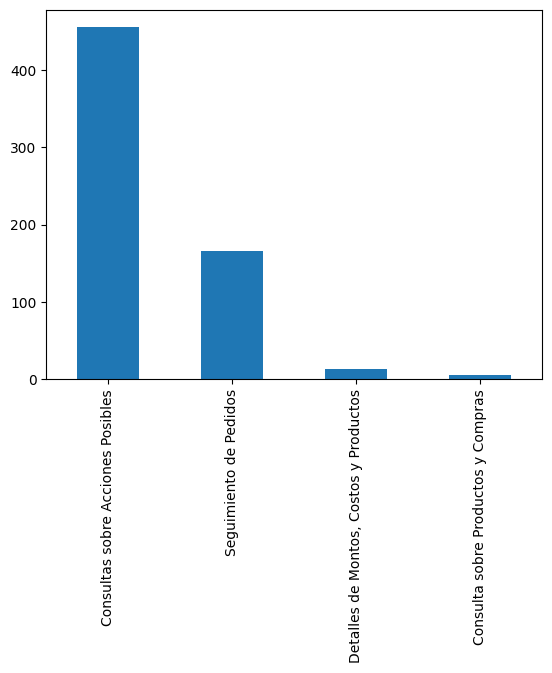

In [59]:
ax = corpus_df['LDA_name_topic'].value_counts().plot(kind='bar')
plt.show()

LDA generó cuatro tópicos que, distribuidos en el espacio de puntos con PCA, donde se puede observar una clara separación entre los distintos tópicos dentro del espacio (en rosa y azul, siendo los tópicos mayoritarios). Esto indica una capacidad para identificar temas. Proporcionó una separación clara de las conversaciones en categorías específicas, ofreciendo una visión de los temas presentes en las llamadas.

#### **LSA**

Buscando el número óptimo de tokens: 100%|██████████| 14/14 [00:26<00:00,  1.86s/it]


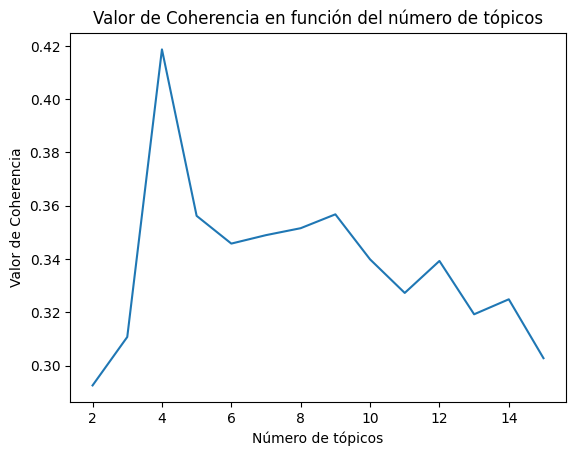


Número óptimo de tópicos: 4


In [22]:
optimal_num_topics = get_optimal_number('lsa', corpus, dictionary, corpus_df.stem_tokens)

In [23]:
lsa_model = models.LsiModel(corpus,
                            num_topics=optimal_num_topics,
                            id2word=dictionary)

In [24]:
# Imprimir los tópicos encontrados
for topic in lsa_model.print_topics():
    print(topic)

(0, '0.316*"si" + 0.278*"ped" + 0.220*"dos" + 0.212*"entonc" + 0.189*"nuev" + 0.167*"hac" + 0.155*"lleg" + 0.155*"pued" + 0.151*"buen" + 0.150*"tres"')
(1, '-0.337*"dos" + 0.263*"entonc" + -0.234*"cuatr" + 0.216*"compr" + 0.214*"hac" + -0.213*"tres" + -0.205*"seis" + 0.196*"dic" + -0.173*"nuev" + -0.172*"siet"')
(2, '-0.317*"dos" + -0.300*"mil" + 0.292*"ped" + 0.242*"favor" + 0.198*"graci" + 0.185*"pued" + -0.167*"tarjet" + -0.165*"cobr" + 0.163*"dia" + -0.159*"entonc"')
(3, '0.594*"tarjet" + -0.253*"si" + -0.229*"product" + 0.200*"compr" + -0.191*"dos" + 0.186*"ped" + 0.131*"entonc" + -0.130*"nuev" + 0.129*"credit" + 0.118*"graci"')


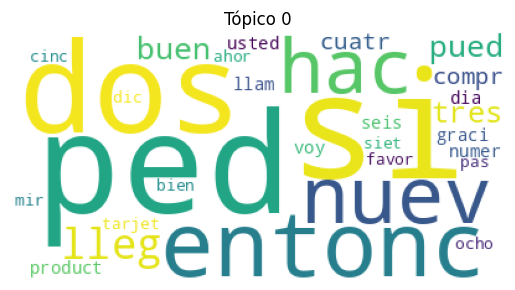

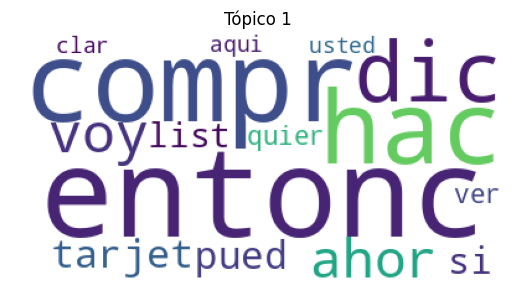

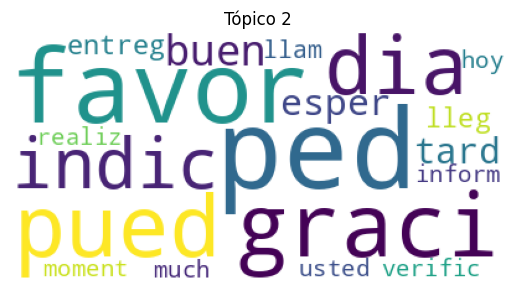

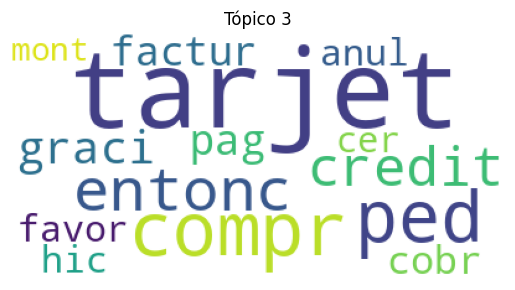

In [25]:
visualizar_topicos(lsa_model)

In [47]:
nombres_topicos_LSA = temas_diccionario = {
    0: 'Seguimiento de Pedidos',
    1: 'Acciones y Compras',
    2: 'Detalles de Pedidos',
    3: 'Transacciones con Tarjeta'
}

In [48]:
# Asignar tópicos usando LSA
lsa_topic_matrix = lsa_model[corpus]

corpus_df['LSA_topic'] = [max(doc, key=lambda x: x[1])[0] if doc else None for doc in lsa_topic_matrix]
corpus_df['LSA_name_topic'] = corpus_df['LSA_topic'].map(nombres_topicos_LSA)

# Mostrar el DataFrame resultante
corpus_df[['Pregunta', 'LDA_name_topic', 'LSA_name_topic']][:10]

Pregunta  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       al final . Hola , buenas tardes con Karen . Mira , te quiero hacer una pregunta . Hay una máquina para hacer arepa que se y aparece con un precio de veinte mil pesos , pero por la página , por la , , aparece a treinta y cinco mil no si me puedes corrob

In [28]:
visualizar_textos_pca(corpus_df, 'prepro', 'LSA_topic')

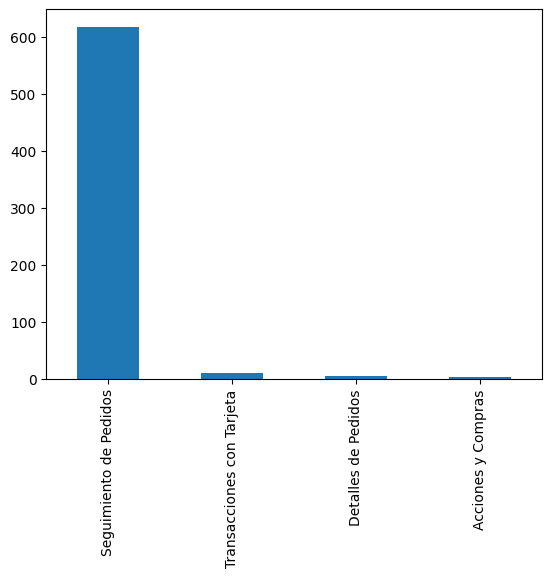

In [58]:
ax = corpus_df['LSA_name_topic'].value_counts().plot(kind='bar')
plt.show()

La aplicación de LSA para la asignación de tópicos no demostró un rendimiento óptimo, como se evidencia al visualizar la distribución de tópicos en el plano. A pesar de contar con la misma cantidad de tópicos que LDA, se observa que predominantemente solo el tópico 0, en color azul, abarca la mayor parte del espacio, indicando una limitada capacidad del modelo para discernir y asignar distintos temas de manera efectiva.

#### **BERTopic**

In [29]:
# Crear un modelo BERTopic
bert_model = BERTopic()

bert_topics, document_embeddings  = bert_model.fit_transform(corpus_df['tokens'].apply(lambda x : ' '.join(x  )))

corpus_df['BERT_topic'] = bert_topics # asigno los topicos

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [31]:
# Visualizar los tópicos
bert_model.visualize_topics()

In [32]:
bert_model.topic_labels_

{-1: '-1_pedido_si_dos_entonces',
 0: '0_pedido_si_gracias_dia',
 1: '1_cuatro_dos_si_pedido',
 2: '2_si_productos_dos_producto',
 3: '3_tarjeta_credito_si_entonces',
 4: '4_si_nueve_telefono_pedido',
 5: '5_internet_si_dia_entonces',
 6: '6_producto_cambiaron_cambiar_si',
 7: '7_carro_ahora_entonces_voy',
 8: '8_dos_mil_seis_cobraron'}

In [33]:
for topic_id, label in enumerate(bert_model.topic_labels_):
    keywords = bert_model.get_topic(topic_id)
    print(f"Tópico {topic_id}: {label} - Palabras Clave: {keywords}")

Tópico 0: -1 - Palabras Clave: [('pedido', 0.05452087680339485), ('si', 0.040148883861051865), ('gracias', 0.03361550128992203), ('dia', 0.03123424208109976), ('favor', 0.02869036420713982), ('seis', 0.02705239617531442), ('hoy', 0.026948539088835703), ('entonces', 0.02686687501273327), ('nueve', 0.02532403538587682), ('bien', 0.025023449194920434)]
Tópico 1: 0 - Palabras Clave: [('cuatro', 0.03812031454176887), ('dos', 0.03792330878174128), ('si', 0.037010556617851215), ('pedido', 0.033119069651839916), ('mil', 0.03309712474014047), ('tres', 0.03139303532334484), ('dia', 0.030949942015289767), ('veinticinco', 0.027759448222328485), ('compra', 0.02717546219238099), ('seis', 0.027138510760199047)]
Tópico 2: 1 - Palabras Clave: [('si', 0.04286925700226303), ('productos', 0.04221800554934867), ('dos', 0.04136592697718973), ('producto', 0.03351429437422154), ('entonces', 0.030253428023597553), ('tres', 0.028077718612930153), ('nueve', 0.026188268339521825), ('cuatro', 0.02618735542895288),

In [52]:
nombres_topicos_BERT = {
    -1: 'Tópico No Identificado', # outliers
    0: 'Consulta de Pedidos',
    1: 'Detalles de Compras y Pedidos',
    2: 'Consulta de Productos y Compras',
    3: 'Transacciones con Tarjeta de Crédito',
    4: 'Consultas de pedidos con seguimiento por Teléfono',
    5: 'Problemas con Compras por Internet',
    6: 'Cambios y Devoluciones de Productos',
    7: 'Consulta sobre Carrito de Compras',
    8: 'Problemas con Montos Cobrados',
}

In [53]:
corpus_df['BERT_name_topic'] = corpus_df['BERT_topic'].map(nombres_topicos_BERT)

In [54]:
corpus_df[['Pregunta', 'LDA_name_topic', 'LSA_name_topic', 'BERT_name_topic']][:10]

Pregunta  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       al final . Hola , buenas tardes con Karen . Mira , te quiero hacer una pregunta . Hay una máquina para hacer arepa que se y aparece con un precio de veinte mil pesos , pero por la página , por la , , aparece a treinta y cinco mil no si me puedes corrob

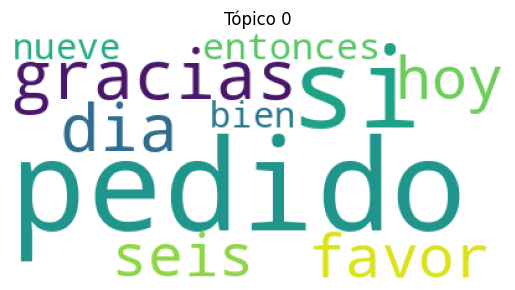

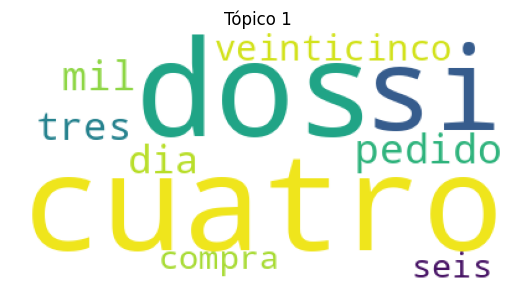

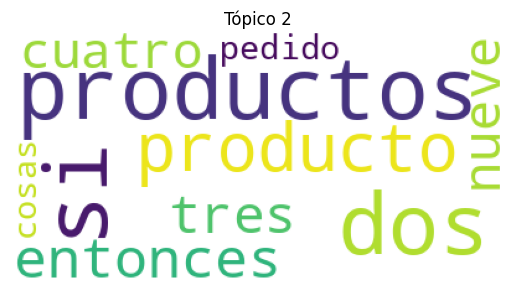

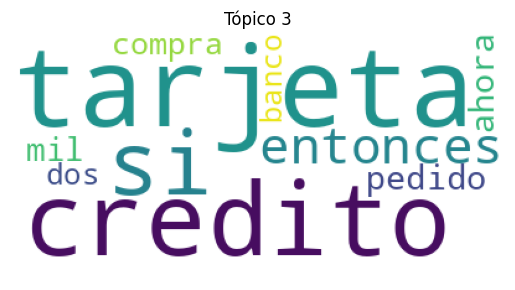

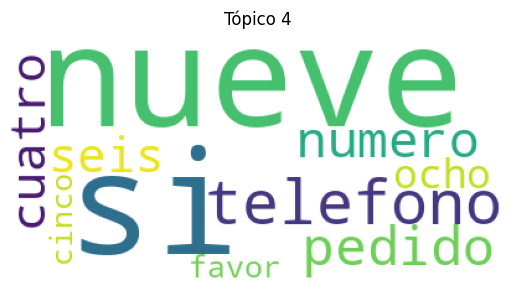

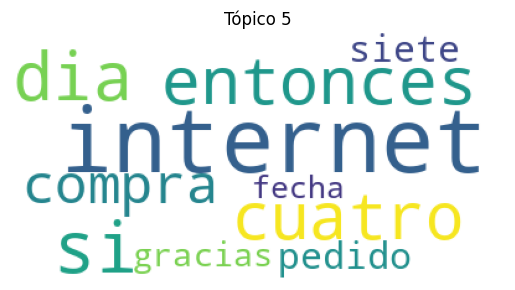

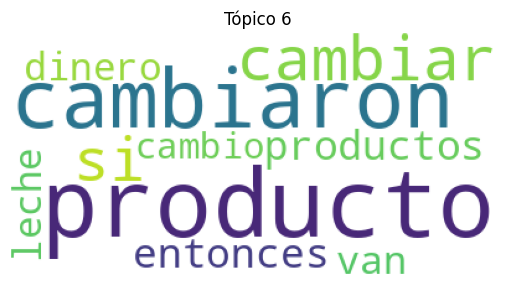

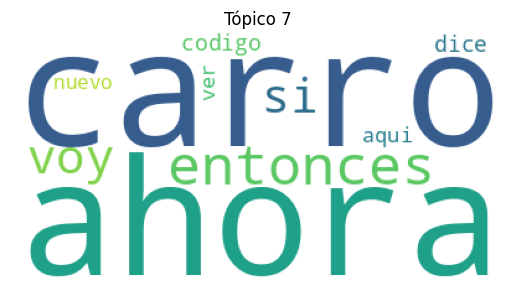

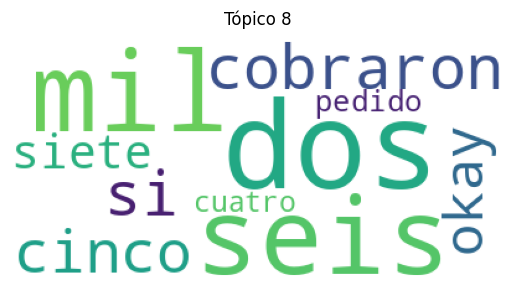

In [34]:
def visualizar_topicos_bert(modelo_bertopic):
    for i in range(len(modelo_bertopic.topic_labels_)):
      try:
        palabras_clave = modelo_bertopic.get_topic(i)
        frecuencias = {palabra: frecuencia for palabra, frecuencia in palabras_clave}

        plt.figure()
        plt.imshow(WordCloud(background_color='white').fit_words(frecuencias))
        plt.axis("off")
        plt.title("Tópico " + str(i))
        plt.show()
      except:
        pass

visualizar_topicos_bert(bert_model)

In [36]:
visualizar_textos_pca(corpus_df, 'prepro', 'BERT_topic')

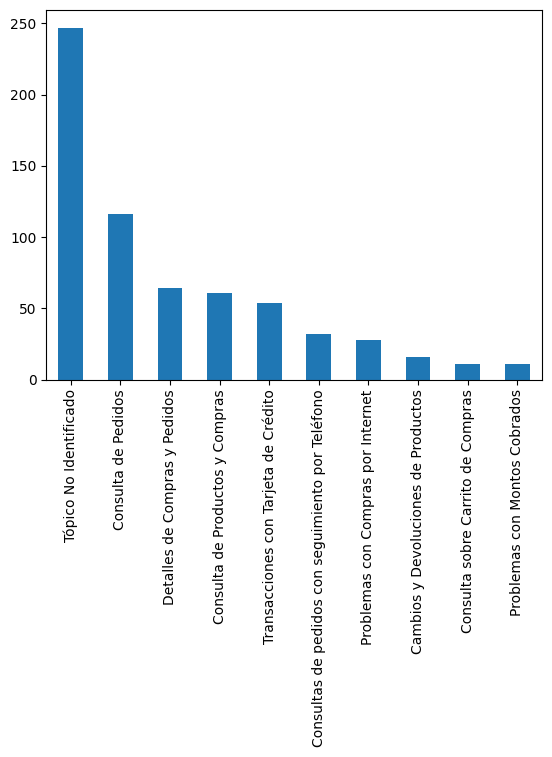

In [57]:
ax = corpus_df['BERT_name_topic'].value_counts().plot(kind='bar')
plt.show()

BERTopic asignó 8 tópicos diferentes, los cuales están claramente diferenciados en la visualización de embeddings con PCA. Esta diversidad de tópicos sugiere una capacidad más robusta para capturar la variedad de discusiones en las llamadas. La asignación más detallada de temas indica que BERTopic pudo entender mejor la complejidad y diversidad de las conversaciones. Sin embargo, muchas conversaciones no pudieron ser asignadas a ningun tópico (outliers). La presencia de tópicos asignados como outliers sugiere que hay llamadas que pueden no ajustarse a las categorías principales definidas por BERTopic.

### **Guardo los resultados obtenidos**

In [56]:
corpus_df.to_csv('resultados_analisis_topicos.csv', index = False)

### **Conclusión**

LSA parece tener dificultades para distinguir claramente los tópicos, ya que tiende a agrupar la mayoría en uno solo. LDA, por otro lado, mejora significativamente al generar cuatro tópicos distintos, con los que logra una distribución más equitativa de los temas. BERTopic sobresale al asignar 8 tópicos bien diferenciados, indicando una comprensión más profunda y detallada de la diversidad temática presente en las llamadas. Sin embargo, es importante destacar que, aunque BERTopic demuestra una capacidad robusta para capturar la variabilidad de las conversaciones, la presencia mayoritaria de tópicos asignados como outliers (tópico no identificado) sugiere la necesidad de ajustes adicionales.